In [145]:
import skimage.io as skio
import matplotlib.pyplot as plt
import numpy as np
import skimage.morphology as morpho
import skimage.segmentation as segmentation
import skimage
from skimage.transform import rescale, resize
from skimage.measure import label, regionprops, regionprops_table
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.color import label2rgb

In [174]:
def line_strell(l, mode='v'):
  strell = np.ones(l) if mode == 'v' else np.ones((l[-1], l[0]))
  return strell

def rgb2gray(u):
    return 0.2989 * u[:,:,0] + 0.5870 * u[:,:,1] + 0.1140 * u[:,:,2]

def equalize_histogram(img):
    img_flat = img.flatten()
    cdf, bins = skimage.exposure.cumulative_distribution(img_flat, nbins=256)
    cdf_normalized = cdf / cdf[-1]
    img_equalized_flat = np.interp(img_flat, bins, cdf_normalized * 255).astype(np.uint8)
    new_image = img_equalized_flat.reshape(img.shape)
    return new_image

def show_images(images, titles=None):
    """
    Displays a list or array of images in a grid.
    
    Args:
        images (list or array): List/array of images to display.
        titles (list or array): Optional titles for each image.
        cmap (str): Colormap to use for displaying images.
    """
    num_images = len(images)
    cols = int(np.ceil(np.sqrt(num_images)))
    rows = int(np.ceil(num_images / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.ravel()
    
    for i in range(len(images)):
        axes[i].imshow(images[i])
        if titles:
            axes[i].set_title(titles[i])
        axes[i].axis('off')
   
    for i in range(len(images), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

## Segmentation of shelves

In this part we look for a clean, fast method to find bookshelves, which will be the input component for the next parts of the project.

In [ ]:
img = skio.imread('books1.jpg')
plt.imshow(img)

In [ ]:
img_gray = rgb2gray(skio.imread('books1.jpg'))
img = skio.imread('books1.jpg')

img = img_gray

img = resize(
    img, (500, 500), anti_aliasing=True
)

img = equalize_histogram(img)

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(img_eq, cmap='gray')
plt.show()

In [59]:
img.shape

(500, 500)

In [ ]:
strell = line_strell((2, 10), 'v')
morpho_grad = morpho.dilation(img, strell) - morpho.erosion(img, strell)

plt.figure(figsize=(5, 5))

regions = regionprops(img)

plt.imshow(morpho_grad,cmap = "gray")
plt.show()

In [ ]:
# Step 1: Thresholding
thresh = threshold_otsu(morpho_grad)
binary = morpho_grad > thresh

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Morphological Gradient")
plt.imshow(morpho_grad, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Binarized Image")
plt.imshow(binary, cmap="gray")
plt.show()

# Step 2: Label connected regions
labeled_image = label(binary)
plt.figure(figsize=(6, 6))
plt.title("Labeled Regions")
plt.imshow(label2rgb(labeled_image, image=img, bg_label=0))
plt.axis("off")
plt.show()

# Step 3: Extract region properties
regions = regionprops(labeled_image)

bounding_boxes = []

for region in regions:
    # Filter regions based on size and aspect ratio
    min_area = 500          # Minimum area to be considered a book
    min_aspect_ratio = 0.5  # Minimum aspect ratio for a book
    max_aspect_ratio = 5.0  # Maximum aspect ratio for a book
    
    if region.area >= min_area:
        aspect_ratio = region.bbox[3] / (region.bbox[2] - region.bbox[0])
        if min_aspect_ratio < aspect_ratio < max_aspect_ratio:
            bounding_boxes.append(region.bbox)  # Append valid bounding boxes

# Step 4: Visualize bounding boxes on original image
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img, cmap="gray")
ax.set_title("Detected Books")
ax.axis("off")

for bbox in bounding_boxes:
    # Draw rectangles around detected books
    min_row, min_col, max_row, max_col = bbox
    rect = plt.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
                          edgecolor="red", linewidth=2, fill=False)
    ax.add_patch(rect)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from sklearn.cluster import DBSCAN

# Extracting bounding boxes from labeled regions
def extract_bounding_boxes(regions):
    bounding_boxes = []
    for region in regions:
        if region.area > 50:  # Ignore tiny regions
            bounding_boxes.append(region.bbox)
    return np.array(bounding_boxes)

# Clustering bounding boxes by y-position (vertical proximity)
def group_books_by_shelves(bounding_boxes, eps=30):
    y_centers = [(box[0] + box[2]) / 2 for box in bounding_boxes]
    y_centers = np.array(y_centers).reshape(-1, 1)

    # Use DBSCAN clustering to group by vertical proximity
    clustering = DBSCAN(eps=eps, min_samples=1).fit(y_centers)
    labels = clustering.labels_

    grouped_boxes = []
    for label in np.unique(labels):
        group = bounding_boxes[labels == label]
        grouped_boxes.append(group)

    return grouped_boxes

# Combine bounding boxes horizontally to form shelf-level boxes
def merge_bounding_boxes(boxes):
    x_min = min(box[1] for box in boxes)
    x_max = max(box[3] for box in boxes)
    y_min = min(box[0] for box in boxes)
    y_max = max(box[2] for box in boxes)
    return (y_min, x_min, y_max, x_max)

# Visualizing grouped shelves
def visualize_shelves(image, shelves):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    for shelf in shelves:
        y_min, x_min, y_max, x_max = shelf
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, 
                                          edgecolor='red', facecolor='none', linewidth=2))
    plt.title("Detected Shelves")
    plt.axis('off')
    plt.show()

def shelf_area(shelf):
    y_min, x_min, y_max, x_max = shelf
    area = (y_max - y_min) * (x_max - x_min)
    return area

def extend_shelf(shelf):
    y_min, x_min, y_max, x_max = shelf
    if x_max < 499:
        x_max = 499
    return (y_min, x_min, y_max, x_max)

# Apply functions to detect shelves
regions = regionprops(label(binary))
bounding_boxes = extract_bounding_boxes(regions)
grouped_boxes = group_books_by_shelves(bounding_boxes)

# Merge bounding boxes within each shelf group
shelves = [merge_bounding_boxes(group) for group in grouped_boxes]

shelves = [extend_shelf(shelf) for shelf in shelves if shelf_area(shelf) > 80000]

for shelf in shelves:
    print(shelf, shelf_area(shelf))

# Visualize the detected shelves
visualize_shelves(img, shelves)

In [178]:
def preprocess(img):
    """
    Preprocesses the input image by converting it to grayscale, resizing it, 
    and applying histogram equalization.

    Args:
        img (numpy.ndarray): The input RGB image.

    Returns:
        numpy.ndarray: The preprocessed grayscale image.
    """
    img_gray = rgb2gray(img)
    img_resized = resize(
        img_gray, (500, 500), anti_aliasing=True
    )
    img_eq = equalize_histogram(img_resized)
    return img_eq

def extract_bounding_boxes(regions):
    bounding_boxes = []
    for region in regions:
        if region.area > 50:
            bounding_boxes.append(region.bbox)
    return np.array(bounding_boxes)

# Clustering bounding boxes by y-position (vertical proximity)
def group_books_by_shelves(bounding_boxes, eps=30):
    y_centers = [(box[0] + box[2]) / 2 for box in bounding_boxes]
    y_centers = np.array(y_centers).reshape(-1, 1)

    # Use DBSCAN clustering to group by vertical proximity
    clustering = DBSCAN(eps=eps, min_samples=1).fit(y_centers)
    labels = clustering.labels_

    grouped_boxes = []
    for label in np.unique(labels):
        group = bounding_boxes[labels == label]
        grouped_boxes.append(group)

    return grouped_boxes

def merge_bounding_boxes(boxes):
    x_min = min(box[1] for box in boxes)
    x_max = max(box[3] for box in boxes)
    y_min = min(box[0] for box in boxes)
    y_max = max(box[2] for box in boxes)
    return (y_min, x_min, y_max, x_max)

def visualize_shelves(image, shelves):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    for shelf in shelves:
        y_min, x_min, y_max, x_max = shelf
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, 
                                          edgecolor='red', facecolor='none', linewidth=2))
    plt.title("Detected Shelves")
    plt.axis('off')
    plt.show()

def shelf_area(shelf):
    y_min, x_min, y_max, x_max = shelf
    area = (y_max - y_min) * (x_max - x_min)
    return area

def extend_shelf(shelf):
    y_min, x_min, y_max, x_max = shelf
    if x_max < 499:
        x_max = 499
    return (y_min, x_min, y_max, x_max)

def find_shelves(img):
    """
    Detects bookshelves in an image by preprocessing the image, 
    applying morphological operations, and finding shelf bounding boxes.

    Args:
        img (numpy.ndarray): The input RGB image.

    Returns:
        list: A list of bounding boxes for the detected shelves. Each bounding 
        box is represented as [y_min, x_min, y_max, x_max].
    """
    # Step 0: Pre-processing
    img = preprocess(img)

    # Step 1: Apply morphological gradient
    strell = line_strell((2, 10), 'v')
    morpho_grad = morpho.dilation(img, strell) - morpho.erosion(img, strell)
    
    # Step 2: Thresholding with Otsu's method
    thresh = threshold_otsu(morpho_grad)
    binary = morpho_grad > thresh
    
    # Step 3: Label connected regions
    labeled_image = label(binary)

    # Step 4: Find region props
    regions = regionprops(label(binary))

    # Step 5: Find and group bounding boxes
    bounding_boxes = extract_bounding_boxes(regions)
    grouped_boxes = group_books_by_shelves(bounding_boxes)
    
    # Step 6: Merge bounding boxes within each shelf group
    shelves = [merge_bounding_boxes(group) for group in grouped_boxes]

    # Step 7: Filter and post-process the shelves
    shelves = [extend_shelf(shelf) for shelf in shelves if shelf_area(shelf) > 80000]
    
    return shelves


def scale_back(img, shelves):
    """
    Scales bounding boxes back to the original image size after resizing.

    Args:
        img (numpy.ndarray): The original RGB image.
        shelves (list): A list of bounding boxes in the resized image. Each bounding 
        box is represented as [y_min, x_min, y_max, x_max].

    Returns:
        numpy.ndarray: The bounding boxes scaled to the original image size.
    """
    original_height, original_width, _ = img.shape
    resized_height, resized_width = 500, 500
   
    bounding_boxes_resized = shelves
    
    scale_y = original_height / resized_height
    scale_x = original_width / resized_width
    
    bounding_boxes_original = []
    for bbox in bounding_boxes_resized:
        y_min, x_min, y_max, x_max = bbox
        y_min = int(y_min * scale_y)
        x_min = int(x_min * scale_x)
        y_max = int(y_max * scale_y)
        x_max = int(x_max * scale_x)
        bounding_boxes_original.append([y_min, x_min, y_max, x_max])
    
    bounding_boxes_original = np.array(bounding_boxes_original)
    return bounding_boxes_original


def get_shelves(img, shelves, scale=True):
    """
    Extracts the cropped images of the detected shelves from the input image.

    Args:
        img (numpy.ndarray): The original RGB image.
        shelves (list): A list of bounding boxes for the shelves. Each bounding 
        box is represented as [y_min, x_min, y_max, x_max].
        scale (bool, optional): Whether to scale the bounding boxes back to the 
        original image size. Defaults to True.

    Returns:
        list: A list of cropped images of the shelves.
    """
    if scale:
        shelves = scale_back(img, shelves)
    shelf_images = []
    for shelf in shelves:
        y_min, x_min, y_max, x_max = shelf
        cropped_image = img[y_min:y_max, x_min:x_max]
        shelf_images.append(cropped_image)
    return shelf_images


def visualize_shelves_rgb(img, shelves):
    """
    Visualizes the detected shelves on the original RGB image by drawing bounding boxes.

    Args:
        img (numpy.ndarray): The original RGB image.
        shelves (list): A list of bounding boxes for the shelves. Each bounding 
        box is represented as [y_min, x_min, y_max, x_max].

    Returns:
        None
    """
    shelves = scale_back(img, shelves)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    for shelf in shelves:
        y_min, x_min, y_max, x_max = shelf
        plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, 
                                          edgecolor='red', facecolor='none', linewidth=2))
    plt.title("Detected Shelves")
    plt.axis('off')
    plt.show()

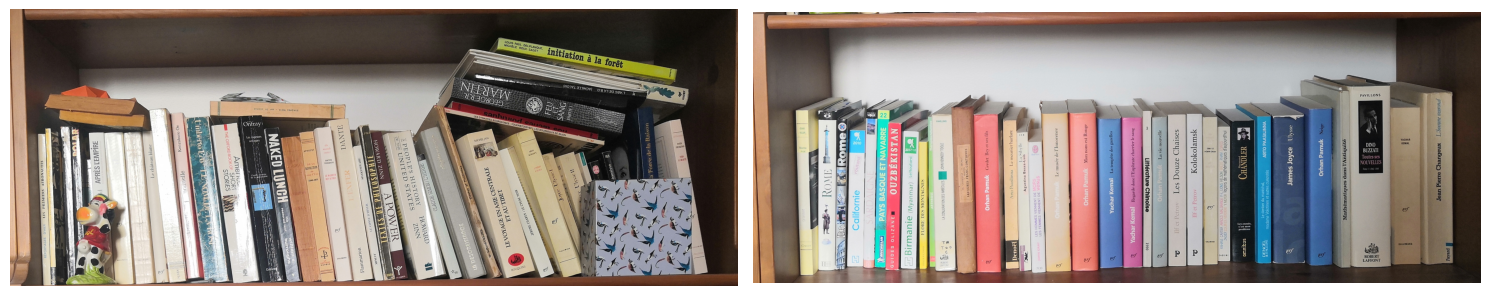

In [179]:
img = skio.imread('books1.jpg')
shelves = find_shelves(img)
img_pre = preprocess(img)
#visualize_shelves(img_pre, shelves)
#visualize_shelves_rgb(img, shelves)
shelf_images = get_shelves(img, shelves)
show_images(shelf_images)